# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)
global threshold_low1, threshold_high1, threshold_low2, threshold_high2
threshold_low1 = 0 #300 works
threshold_high1 = 60
threshold_low2 = 500 #300 works
threshold_high2 = 2000

maxiter = 21
numcoords = 2
selection_model = 0 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5+(((x+5)*(5--5))/(51+5)))
def ynew(y): 
    return (-5+(((y+2)*(5--5))/(53+2)))

def hblau(x):
       
#     return ((1.5-(x[0])+(x[0]*x[1]))**2)+ ((2.25-(x[0])+(x[0]*(x[1]**2)))**2)+ ((2.625-(x[0])+(x[0]*(x[1]**3)))**2)
    return ((((x[0]**2)+(x[1])-11)**2)+(((x[0])+((x[1])**2)-7)**2))

def hblauColor(x, threshold_low1, threshold_high1, threshold_low2, threshold_high2):
    
    if (threshold_low1<hblau((xnew(x[0]),xnew(x[1])))<threshold_high1)|(threshold_low2<hblau((xnew(x[0]),xnew(x[1])))<threshold_high2):
        return 1
    else:
        return 0
      

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zhblau
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .2  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zhblau = []
    hblaucoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(77000):
        Zhblau.append(hblauColor(hblaucoords[i],threshold_low1,threshold_high1,threshold_low2,threshold_high2))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zhblau)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(77000):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


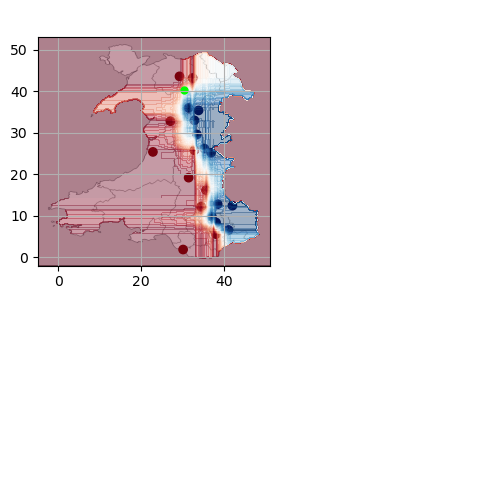

iteration  1
Accuracy is 0.42369181577814674
iteration  2
Accuracy is 0.8087068806493267
iteration  3
Accuracy is 0.6213798192215458
iteration  4
Accuracy is 0.741468363770522
iteration  5
Accuracy is 0.7862325524196028
iteration  6
Accuracy is 0.8177458033573142
iteration  7
Accuracy is 0.8030498677980692
iteration  8
Accuracy is 0.8275840865768923
iteration  9
Accuracy is 0.8361618397589621
iteration  10
Accuracy is 0.8274303634015864
iteration  11
Accuracy is 0.8271229170509746
iteration  12
Accuracy is 0.8448625714812765
iteration  13
Accuracy is 0.8604501014572957
iteration  14
Accuracy is 0.8579905306524012
iteration  15
Accuracy is 0.8603271229170509
iteration  16
Accuracy is 0.8691815778146713
iteration  17
Accuracy is 0.8736395498985428
iteration  18
Accuracy is 0.8781282666174752
iteration  19
Accuracy is 0.8532866014880404
iteration  20
Accuracy is 0.8633093525179856
iteration  21
Accuracy is 0.8671216872655721
experiment:  1


<IPython.core.display.Javascript object>


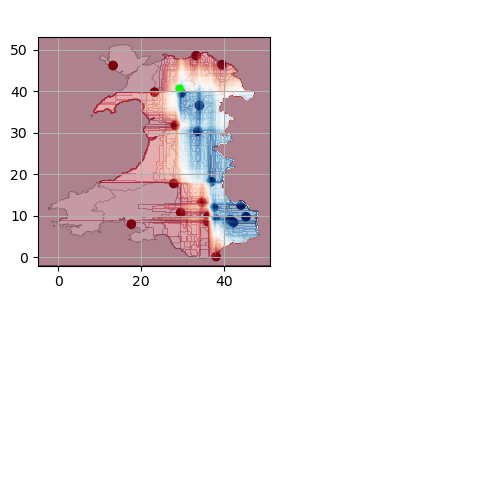

iteration  1
Accuracy is 0.6418864908073542
iteration  2
Accuracy is 0.635614585254873
iteration  3
Accuracy is 0.6732767632048208
iteration  4
Accuracy is 0.7315071020106991
iteration  5
Accuracy is 0.7188710570005534
iteration  6
Accuracy is 0.7312918895652709
iteration  7
Accuracy is 0.803511037323987
iteration  8
Accuracy is 0.7665867306155076
iteration  9
Accuracy is 0.585377851564902
iteration  10
Accuracy is 0.5948779437988071
iteration  11
Accuracy is 0.7405767693537477
iteration  12
Accuracy is 0.7698149172969316
iteration  13
Accuracy is 0.7496156920617352
iteration  14
Accuracy is 0.7883539322388243
iteration  15
Accuracy is 0.8442476787800529
iteration  16
Accuracy is 0.8480600135276394
iteration  17
Accuracy is 0.8581749984627682
iteration  18
Accuracy is 0.852395007071266
iteration  19
Accuracy is 0.8254012174875485
iteration  20
Accuracy is 0.8459386337084179
iteration  21
Accuracy is 0.8482752259730677
experiment:  2


<IPython.core.display.Javascript object>


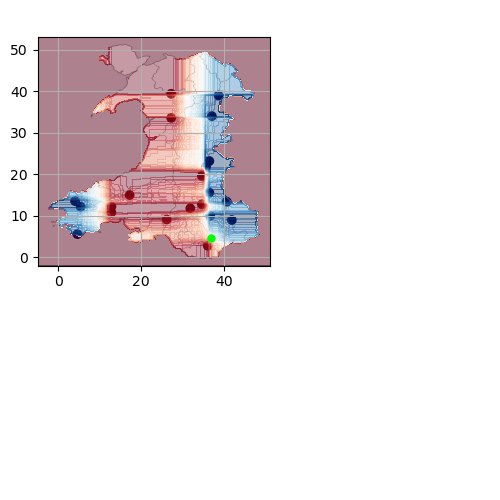

iteration  1
Accuracy is 0.40044887167189325
iteration  2
Accuracy is 0.3990346184590789
iteration  3
Accuracy is 0.4056139703621718
iteration  4
Accuracy is 0.4110250261329398
iteration  5
Accuracy is 0.4132693844924061
iteration  6
Accuracy is 0.41065609051220564
iteration  7
Accuracy is 0.666051773965443
iteration  8
Accuracy is 0.716104039845047
iteration  9
Accuracy is 0.7128451085285618
iteration  10
Accuracy is 0.731138166389965
iteration  11
Accuracy is 0.7714751275902355
iteration  12
Accuracy is 0.7839267047900141
iteration  13
Accuracy is 0.8068314579105946
iteration  14
Accuracy is 0.8310582303388059
iteration  15
Accuracy is 0.8420340650556478
iteration  16
Accuracy is 0.8400356637766709
iteration  17
Accuracy is 0.8519338375453483
iteration  18
Accuracy is 0.8428026809321774
iteration  19
Accuracy is 0.8516878804648589
iteration  20
Accuracy is 0.8527639426920003
iteration  21
Accuracy is 0.8460616122486626
experiment:  3


<IPython.core.display.Javascript object>


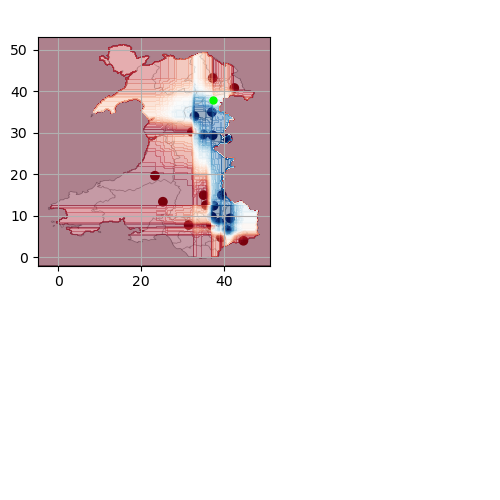

iteration  1
Accuracy is 0.6821004734673799
iteration  2
Accuracy is 0.684990469163131
iteration  3
Accuracy is 0.7014081042858021
iteration  4
Accuracy is 0.7530283465535265
iteration  5
Accuracy is 0.7887843571296809
iteration  6
Accuracy is 0.7790997970854086
iteration  7
Accuracy is 0.769691938756687
iteration  8
Accuracy is 0.7934575416589805
iteration  9
Accuracy is 0.8256164299329767
iteration  10
Accuracy is 0.8223267539814303
iteration  11
Accuracy is 0.8111971960892824
iteration  12
Accuracy is 0.821957818360696
iteration  13
Accuracy is 0.8074463506118182
iteration  14
Accuracy is 0.7995142347660333
iteration  15
Accuracy is 0.8200209063518415
iteration  16
Accuracy is 0.8558384061981185
iteration  17
Accuracy is 0.8599581872963168
iteration  18
Accuracy is 0.868781897558876
iteration  19
Accuracy is 0.8687204082887536
iteration  20
Accuracy is 0.8631556293426798
iteration  21
Accuracy is 0.8680132816823465
experiment:  4


<IPython.core.display.Javascript object>


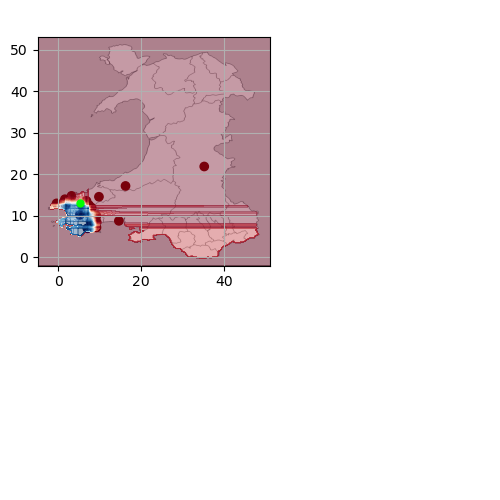

iteration  1
Accuracy is 0.5255180471007809
iteration  2
Accuracy is 0.6975957695382156
iteration  3
Accuracy is 0.7253581749984628
iteration  4
Accuracy is 0.7289245526655599
iteration  5
Accuracy is 0.7282174260591526
iteration  6
Accuracy is 0.7333517801143701
iteration  7
Accuracy is 0.7283096599643363
iteration  8
Accuracy is 0.7341818852610219
iteration  9
Accuracy is 0.7302773166082519
iteration  10
Accuracy is 0.7316608251860051
iteration  11
Accuracy is 0.7349812457726127
iteration  12
Accuracy is 0.7338436942753489
iteration  13
Accuracy is 0.7333517801143701
iteration  14
Accuracy is 0.7365184775256718
iteration  15
Accuracy is 0.7369181577814672
iteration  16
Accuracy is 0.7375023058476295
iteration  17
Accuracy is 0.7359958187296317
iteration  18
Accuracy is 0.7344278423415114
iteration  19
Accuracy is 0.7355039045686528
iteration  20
Accuracy is 0.7376560290229355
iteration  21
Accuracy is 0.739101026870811
experiment:  5


<IPython.core.display.Javascript object>


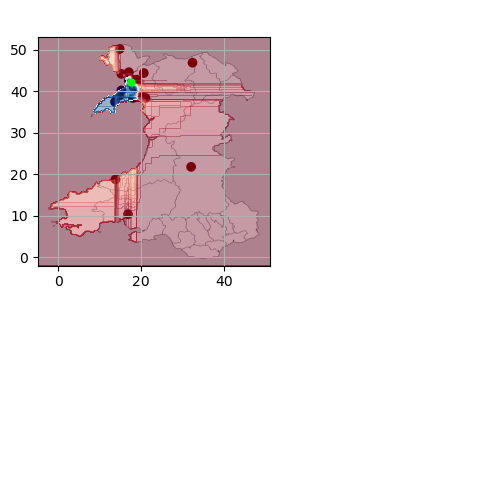

iteration  1
Accuracy is 0.3229109020475927
iteration  2
Accuracy is 0.6595954006025948
iteration  3
Accuracy is 0.6781959048146099
iteration  4
Accuracy is 0.7089405398757916
iteration  5
Accuracy is 0.7185021213798192
iteration  6
Accuracy is 0.7199163745926336
iteration  7
Accuracy is 0.7224989239377728
iteration  8
Accuracy is 0.727602533357929
iteration  9
Accuracy is 0.7245280698518108
iteration  10
Accuracy is 0.7241898788661378
iteration  11
Accuracy is 0.7288938080304986
iteration  12
Accuracy is 0.728278915329275
iteration  13
Accuracy is 0.7276332779929903
iteration  14
Accuracy is 0.7278792350734796
iteration  15
Accuracy is 0.7286785955850704
iteration  16
Accuracy is 0.7293549775564164
iteration  17
Accuracy is 0.7294164668265388
iteration  18
Accuracy is 0.7295394453667835
iteration  19
Accuracy is 0.7296009346369059
iteration  20
Accuracy is 0.7294779560966611
iteration  21
Accuracy is 0.7292012543811105
experiment:  6


<IPython.core.display.Javascript object>


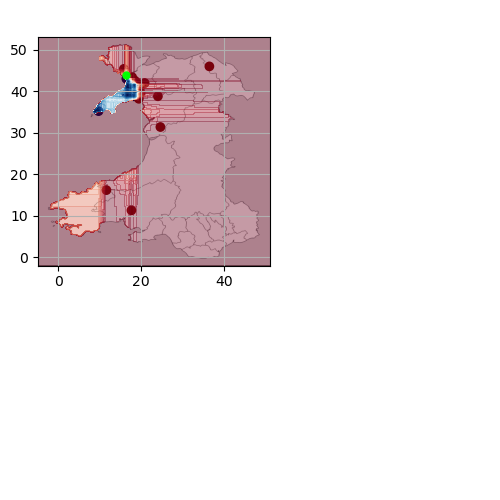

iteration  1
Accuracy is 0.6985795978601734
iteration  2
Accuracy is 0.6990715120211524
iteration  3
Accuracy is 0.7199471192276947
iteration  4
Accuracy is 0.6288815101764742
iteration  5
Accuracy is 0.6781036709094264
iteration  6
Accuracy is 0.6879726987640656
iteration  7
Accuracy is 0.727756256533235
iteration  8
Accuracy is 0.7264957264957265
iteration  9
Accuracy is 0.7288015741253151
iteration  10
Accuracy is 0.7263420033204205
iteration  11
Accuracy is 0.728955297300621
iteration  12
Accuracy is 0.728432638504581
iteration  13
Accuracy is 0.7289860419356822
iteration  14
Accuracy is 0.7284018938695198
iteration  15
Accuracy is 0.7290475312058046
iteration  16
Accuracy is 0.7290475312058046
iteration  17
Accuracy is 0.7290167865707434
iteration  18
Accuracy is 0.7292319990161716
iteration  19
Accuracy is 0.7292627436512329
iteration  20
Accuracy is 0.7291705097460494
iteration  21
Accuracy is 0.7292627436512329
experiment:  7


<IPython.core.display.Javascript object>


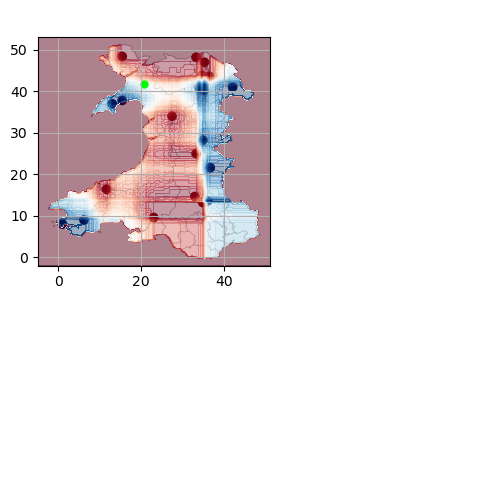

iteration  1
Accuracy is 0.8080304986779807
iteration  2
Accuracy is 0.8055709278730862
iteration  3
Accuracy is 0.7556416405337268
iteration  4
Accuracy is 0.7508454774641825
iteration  5
Accuracy is 0.8169771874807846
iteration  6
Accuracy is 0.8114431531697719
iteration  7
Accuracy is 0.8266002582549346
iteration  8
Accuracy is 0.8342249277501076
iteration  9
Accuracy is 0.8255241960277931
iteration  10
Accuracy is 0.8360388612187173
iteration  11
Accuracy is 0.8417881079751584
iteration  12
Accuracy is 0.6517555186619934
iteration  13
Accuracy is 0.7454651663284757
iteration  14
Accuracy is 0.6943368382217303
iteration  15
Accuracy is 0.8070774149910841
iteration  16
Accuracy is 0.8370841788107976
iteration  17
Accuracy is 0.876898481215028
iteration  18
Accuracy is 0.8877513373916252
iteration  19
Accuracy is 0.8683822173030806
iteration  20
Accuracy is 0.8952837729816147
iteration  21
Accuracy is 0.8818791120949394
experiment:  8


<IPython.core.display.Javascript object>


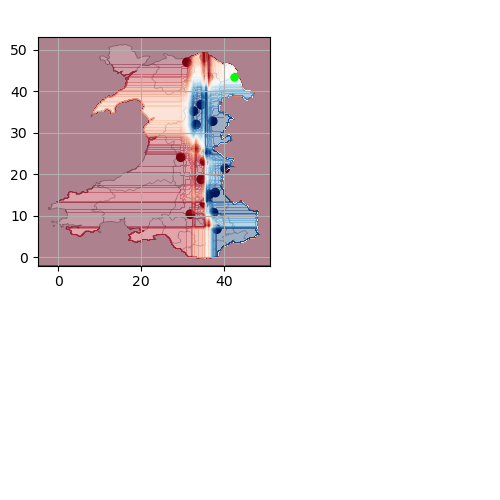

iteration  1
Accuracy is 0.6029945274549591
iteration  2
Accuracy is 0.7207464797392855
iteration  3
Accuracy is 0.7501076062227141
iteration  4
Accuracy is 0.7474943122425137
iteration  5
Accuracy is 0.7486933530098998
iteration  6
Accuracy is 0.7853409580028285
iteration  7
Accuracy is 0.7713521490499908
iteration  8
Accuracy is 0.8101518784972023
iteration  9
Accuracy is 0.7956404107483244
iteration  10
Accuracy is 0.8260468548238332
iteration  11
Accuracy is 0.8317961015802743
iteration  12
Accuracy is 0.8295517432208079
iteration  13
Accuracy is 0.8407735350181393
iteration  14
Accuracy is 0.8326569513619874
iteration  15
Accuracy is 0.8328721638074156
iteration  16
Accuracy is 0.8460616122486626
iteration  17
Accuracy is 0.8565455328045256
iteration  18
Accuracy is 0.8589436143392978
iteration  19
Accuracy is 0.8686281743835701
iteration  20
Accuracy is 0.8646006271905552
iteration  21
Accuracy is 0.8710877451884647
experiment:  9


<IPython.core.display.Javascript object>


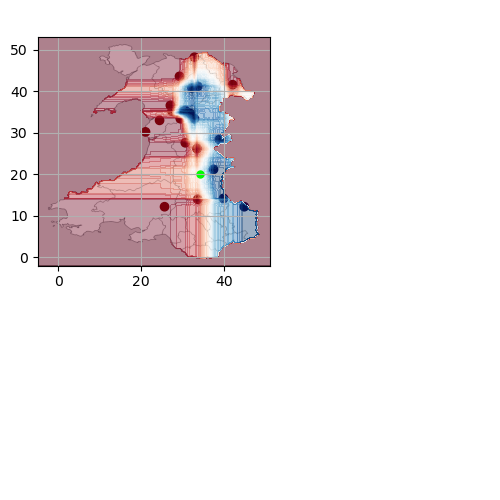

iteration  1
Accuracy is 0.617014081042858
iteration  2
Accuracy is 0.6904015249338991
iteration  3
Accuracy is 0.6987333210354794
iteration  4
Accuracy is 0.7124454282727664
iteration  5
Accuracy is 0.7200086084978171
iteration  6
Accuracy is 0.7098013896575047
iteration  7
Accuracy is 0.7094324540367706
iteration  8
Accuracy is 0.783895960154953
iteration  9
Accuracy is 0.7302773166082519
iteration  10
Accuracy is 0.6986410871302957
iteration  11
Accuracy is 0.6816085593064011
iteration  12
Accuracy is 0.7686158765295455
iteration  13
Accuracy is 0.7980384922830966
iteration  14
Accuracy is 0.8286294041689725
iteration  15
Accuracy is 0.8353932238824325
iteration  16
Accuracy is 0.8763450777839267
iteration  17
Accuracy is 0.8428334255672385
iteration  18
Accuracy is 0.8620795671155383
iteration  19
Accuracy is 0.8618950993051713
iteration  20
Accuracy is 0.865738178687819
iteration  21
Accuracy is 0.8733013589128698
experiment:  10


<IPython.core.display.Javascript object>


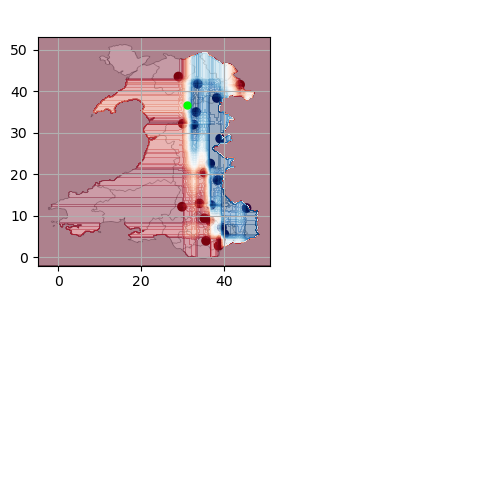

iteration  1
Accuracy is 0.5711430855315748
iteration  2
Accuracy is 0.7501076062227141
iteration  3
Accuracy is 0.7001475742482937
iteration  4
Accuracy is 0.7445120826415791
iteration  5
Accuracy is 0.7452192092479862
iteration  6
Accuracy is 0.742298468917174
iteration  7
Accuracy is 0.7599458894422924
iteration  8
Accuracy is 0.7530283465535265
iteration  9
Accuracy is 0.7798684129619381
iteration  10
Accuracy is 0.790997970854086
iteration  11
Accuracy is 0.7878312734427843
iteration  12
Accuracy is 0.8269384492406076
iteration  13
Accuracy is 0.8547008547008547
iteration  14
Accuracy is 0.8714259361741377
iteration  15
Accuracy is 0.8707188095677304
iteration  16
Accuracy is 0.8651847752567177
iteration  17
Accuracy is 0.8679517924122241
iteration  18
Accuracy is 0.8673368997110005
iteration  19
Accuracy is 0.8700424275963844
iteration  20
Accuracy is 0.8429564041074833
iteration  21
Accuracy is 0.8453852302773166
experiment:  11


<IPython.core.display.Javascript object>


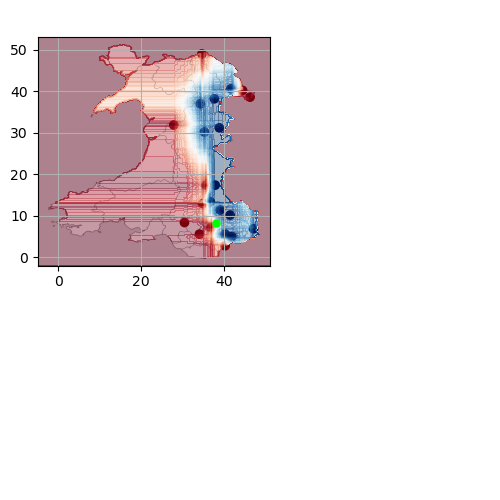

iteration  1
Accuracy is 0.6848367459878252
iteration  2
Accuracy is 0.6974113017278485
iteration  3
Accuracy is 0.7345815655168173
iteration  4
Accuracy is 0.789491483736088
iteration  5
Accuracy is 0.7543503658611572
iteration  6
Accuracy is 0.7529053680132817
iteration  7
Accuracy is 0.7469101641763513
iteration  8
Accuracy is 0.7653262005779992
iteration  9
Accuracy is 0.7670171555063642
iteration  10
Accuracy is 0.7670479001414253
iteration  11
Accuracy is 0.771044702699379
iteration  12
Accuracy is 0.7998831703867675
iteration  13
Accuracy is 0.8042796532005165
iteration  14
Accuracy is 0.8261083440939556
iteration  15
Accuracy is 0.8347783311812089
iteration  16
Accuracy is 0.8357006702330443
iteration  17
Accuracy is 0.8286294041689725
iteration  18
Accuracy is 0.8316731230400295
iteration  19
Accuracy is 0.8479677796224558
iteration  20
Accuracy is 0.8616491422246818
iteration  21
Accuracy is 0.8711184898235258
experiment:  12


<IPython.core.display.Javascript object>


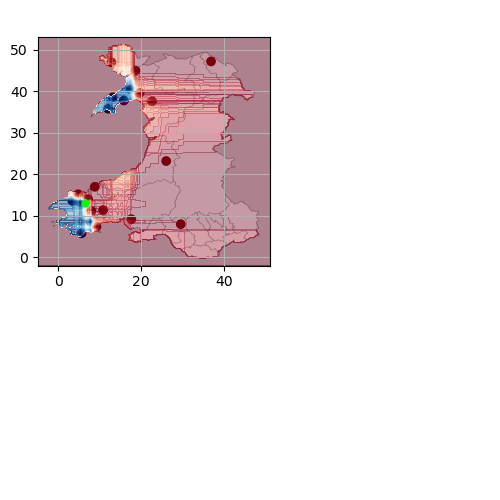

iteration  1
Accuracy is 0.4860111910471623
iteration  2
Accuracy is 0.4311012728278915
iteration  3
Accuracy is 0.492897989300867
iteration  4
Accuracy is 0.6340158642316915
iteration  5
Accuracy is 0.6406259607698457
iteration  6
Accuracy is 0.6810551558752997
iteration  7
Accuracy is 0.7137367029453361
iteration  8
Accuracy is 0.7446965504519462
iteration  9
Accuracy is 0.7407612371641149
iteration  10
Accuracy is 0.7390087929656275
iteration  11
Accuracy is 0.7395621963967288
iteration  12
Accuracy is 0.740269323003136
iteration  13
Accuracy is 0.738578368074771
iteration  14
Accuracy is 0.7441738916559061
iteration  15
Accuracy is 0.7390395376006886
iteration  16
Accuracy is 0.7450347414376192
iteration  17
Accuracy is 0.7451269753428027
iteration  18
Accuracy is 0.7480784603086761
iteration  19
Accuracy is 0.7509992006394884
iteration  20
Accuracy is 0.7538891963352395
iteration  21
Accuracy is 0.7525979216626698
experiment:  13


<IPython.core.display.Javascript object>


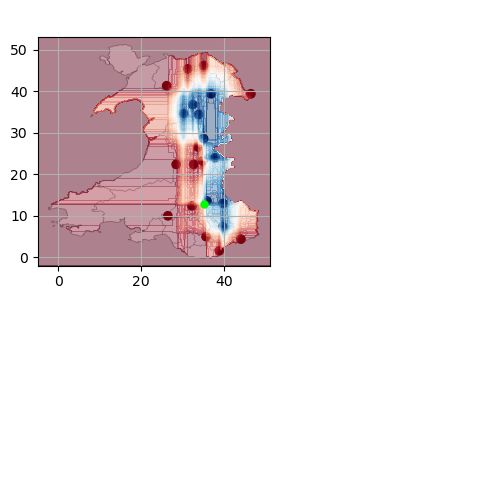

iteration  1
Accuracy is 0.6658365615200148
iteration  2
Accuracy is 0.769200024595708
iteration  3
Accuracy is 0.8040644407550882
iteration  4
Accuracy is 0.7971776425013835
iteration  5
Accuracy is 0.7564717456803788
iteration  6
Accuracy is 0.8051405029822296
iteration  7
Accuracy is 0.8395130049806309
iteration  8
Accuracy is 0.8115353870749554
iteration  9
Accuracy is 0.8012974235995819
iteration  10
Accuracy is 0.8144253827707065
iteration  11
Accuracy is 0.81061304802312
iteration  12
Accuracy is 0.8073233720715736
iteration  13
Accuracy is 0.8127651724774027
iteration  14
Accuracy is 0.8310582303388059
iteration  15
Accuracy is 0.8590665928795426
iteration  16
Accuracy is 0.851534157289553
iteration  17
Accuracy is 0.8418495972452807
iteration  18
Accuracy is 0.850704052142901
iteration  19
Accuracy is 0.8670601979954498
iteration  20
Accuracy is 0.8672139211707557
iteration  21
Accuracy is 0.8665375391994097
experiment:  14


<IPython.core.display.Javascript object>


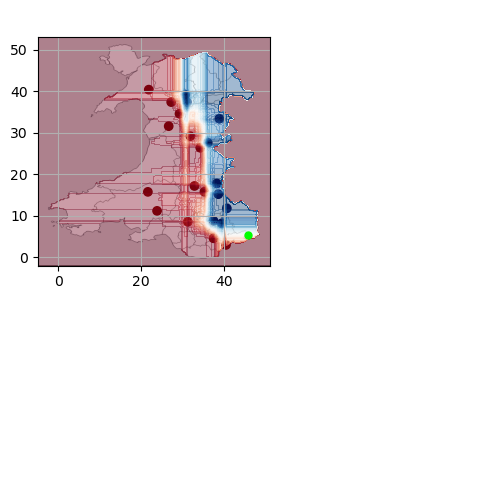

iteration  1
Accuracy is 0.6664207095861772
iteration  2
Accuracy is 0.771229170509746
iteration  3
Accuracy is 0.7549960031974421
iteration  4
Accuracy is 0.7573018508270307
iteration  5
Accuracy is 0.7204697780237349
iteration  6
Accuracy is 0.769015556785341
iteration  7
Accuracy is 0.8191293119350673
iteration  8
Accuracy is 0.6807169648896267
iteration  9
Accuracy is 0.686343233105823
iteration  10
Accuracy is 0.7735965074094571
iteration  11
Accuracy is 0.7792535202607145
iteration  12
Accuracy is 0.8235565393838775
iteration  13
Accuracy is 0.8142409149603395
iteration  14
Accuracy is 0.8245403677058354
iteration  15
Accuracy is 0.8209125007686159
iteration  16
Accuracy is 0.8282297239131772
iteration  17
Accuracy is 0.8201438848920863
iteration  18
Accuracy is 0.836653753919941
iteration  19
Accuracy is 0.8238332410994281
iteration  20
Accuracy is 0.8299206788415422
iteration  21
Accuracy is 0.8330258869827215
experiment:  15


<IPython.core.display.Javascript object>


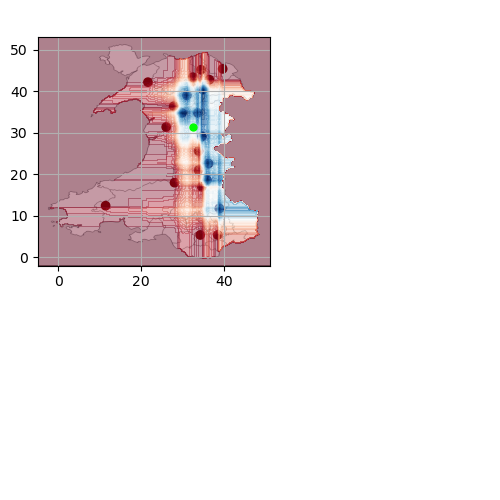

iteration  1
Accuracy is 0.5270860234889012
iteration  2
Accuracy is 0.6456988255549406
iteration  3
Accuracy is 0.7854024472729508
iteration  4
Accuracy is 0.7610526963044949
iteration  5
Accuracy is 0.7855561704482568
iteration  6
Accuracy is 0.7983151939986473
iteration  7
Accuracy is 0.8203283527024534
iteration  8
Accuracy is 0.8031421017032527
iteration  9
Accuracy is 0.8132570866383816
iteration  10
Accuracy is 0.8171616552911517
iteration  11
Accuracy is 0.8555617044825677
iteration  12
Accuracy is 0.8648773289061059
iteration  13
Accuracy is 0.871825616429933
iteration  14
Accuracy is 0.8644469040152494
iteration  15
Accuracy is 0.8523642624362049
iteration  16
Accuracy is 0.8568837237901986
iteration  17
Accuracy is 0.8699194490561397
iteration  18
Accuracy is 0.8556846830228125
iteration  19
Accuracy is 0.8688741314640596
iteration  20
Accuracy is 0.8513189448441247
iteration  21
Accuracy is 0.8598659533911333
experiment:  16


<IPython.core.display.Javascript object>


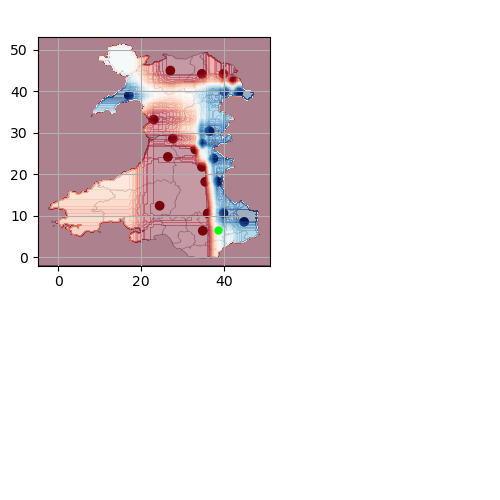

iteration  1
Accuracy is 0.6629773104593248
iteration  2
Accuracy is 0.7475250568775749
iteration  3
Accuracy is 0.647943183914407
iteration  4
Accuracy is 0.644745741868044
iteration  5
Accuracy is 0.6378281989792781
iteration  6
Accuracy is 0.5776609481645453
iteration  7
Accuracy is 0.6241775810121134
iteration  8
Accuracy is 0.6536309414007255
iteration  9
Accuracy is 0.6805939863493821
iteration  10
Accuracy is 0.6871118489823526
iteration  11
Accuracy is 0.7395314517616676
iteration  12
Accuracy is 0.7332595462091865
iteration  13
Accuracy is 0.7765172477402693
iteration  14
Accuracy is 0.7478325032281867
iteration  15
Accuracy is 0.8337022689540675
iteration  16
Accuracy is 0.8272766402262806
iteration  17
Accuracy is 0.8394207710754473
iteration  18
Accuracy is 0.8369612002705528
iteration  19
Accuracy is 0.8397589620611203
iteration  20
Accuracy is 0.8543626637151817
iteration  21
Accuracy is 0.8477218225419664
experiment:  17


<IPython.core.display.Javascript object>


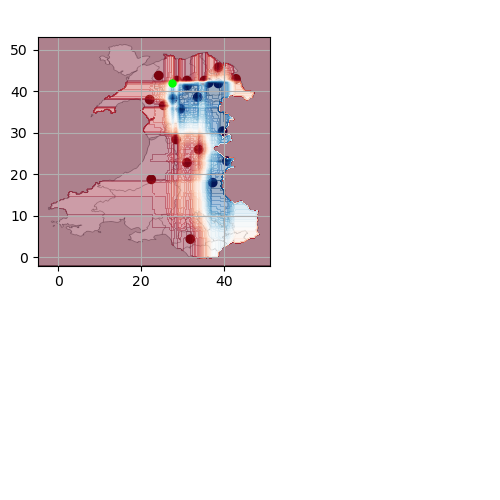

iteration  1
Accuracy is 0.3987271721084671
iteration  2
Accuracy is 0.7413146405952161
iteration  3
Accuracy is 0.4253827707065117
iteration  4
Accuracy is 0.44047838652155197
iteration  5
Accuracy is 0.43694275348951606
iteration  6
Accuracy is 0.5997970854085962
iteration  7
Accuracy is 0.6015802742421448
iteration  8
Accuracy is 0.5721576584885938
iteration  9
Accuracy is 0.7994527454959109
iteration  10
Accuracy is 0.7875545717272336
iteration  11
Accuracy is 0.7931808399434299
iteration  12
Accuracy is 0.7676320482075878
iteration  13
Accuracy is 0.7687081104347291
iteration  14
Accuracy is 0.7551189817376868
iteration  15
Accuracy is 0.7612679087499231
iteration  16
Accuracy is 0.7725511898173769
iteration  17
Accuracy is 0.7653569452130603
iteration  18
Accuracy is 0.7965320051650987
iteration  19
Accuracy is 0.7975773227571789
iteration  20
Accuracy is 0.8325339728217426
iteration  21
Accuracy is 0.8656459447826355
experiment:  18


<IPython.core.display.Javascript object>


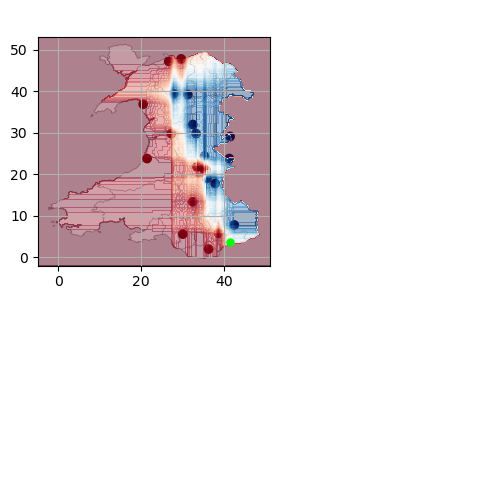

iteration  1
Accuracy is 0.5274242144745742
iteration  2
Accuracy is 0.7672323679517924
iteration  3
Accuracy is 0.728617106314948
iteration  4
Accuracy is 0.7424521920924798
iteration  5
Accuracy is 0.7383016663592203
iteration  6
Accuracy is 0.7639734366353071
iteration  7
Accuracy is 0.8186373977740884
iteration  8
Accuracy is 0.7860788292442968
iteration  9
Accuracy is 0.8019123163008055
iteration  10
Accuracy is 0.815347721822542
iteration  11
Accuracy is 0.8103056016725082
iteration  12
Accuracy is 0.8174691016417636
iteration  13
Accuracy is 0.8145791059460125
iteration  14
Accuracy is 0.7985918957141979
iteration  15
Accuracy is 0.8213121810244113
iteration  16
Accuracy is 0.8167312304002952
iteration  17
Accuracy is 0.7915513742851872
iteration  18
Accuracy is 0.8098136875115293
iteration  19
Accuracy is 0.8181454836131095
iteration  20
Accuracy is 0.8340097153046794
iteration  21
Accuracy is 0.834624608005903
experiment:  19


<IPython.core.display.Javascript object>


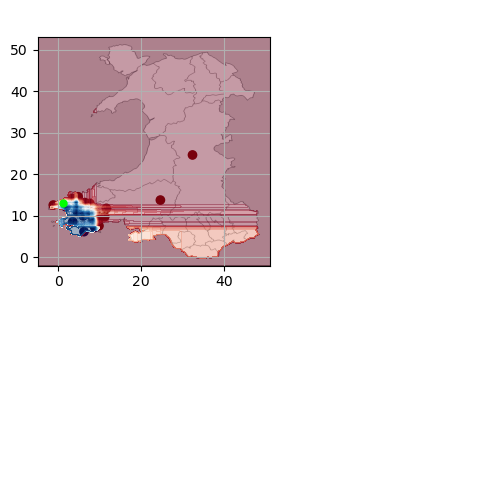

iteration  1
Accuracy is 0.528746233782205
iteration  2
Accuracy is 0.6907704605546332
iteration  3
Accuracy is 0.7110311750599521
iteration  4
Accuracy is 0.6904322695689602
iteration  5
Accuracy is 0.6963044948656459
iteration  6
Accuracy is 0.727264342372256
iteration  7
Accuracy is 0.7293549775564164
iteration  8
Accuracy is 0.7328906105884523
iteration  9
Accuracy is 0.7287400848551928
iteration  10
Accuracy is 0.7294779560966611
iteration  11
Accuracy is 0.7315071020106991
iteration  12
Accuracy is 0.7333825247494312
iteration  13
Accuracy is 0.7349197565024903
iteration  14
Accuracy is 0.7375023058476295
iteration  15
Accuracy is 0.7384861341695874
iteration  16
Accuracy is 0.7375330504826908
iteration  17
Accuracy is 0.7384553895345263
iteration  18
Accuracy is 0.7377175182930579
iteration  19
Accuracy is 0.7383016663592203
iteration  20
Accuracy is 0.7370411363217119
iteration  21
Accuracy is 0.737748262928119
experiment:  20


<IPython.core.display.Javascript object>


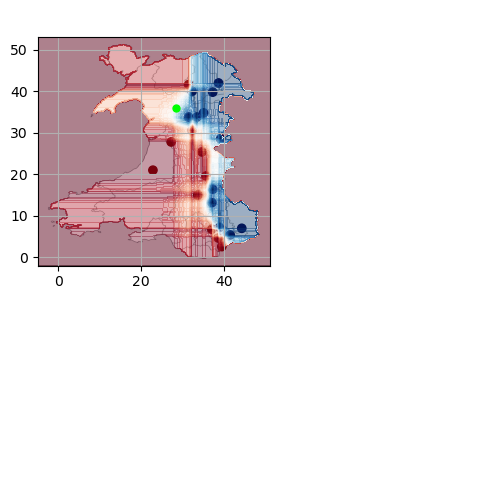

iteration  1
Accuracy is 0.6369980938326262
iteration  2
Accuracy is 0.46627313533788356
iteration  3
Accuracy is 0.36364754350365863
iteration  4
Accuracy is 0.36392424521920924
iteration  5
Accuracy is 0.3651847752567177
iteration  6
Accuracy is 0.6142778085224129
iteration  7
Accuracy is 0.7872778700116829
iteration  8
Accuracy is 0.8182069728832319
iteration  9
Accuracy is 0.7967164729754658
iteration  10
Accuracy is 0.79084424767878
iteration  11
Accuracy is 0.7867859558507041
iteration  12
Accuracy is 0.8143638935005841
iteration  13
Accuracy is 0.8309045071635
iteration  14
Accuracy is 0.8289675951546455
iteration  15
Accuracy is 0.8348705650863925
iteration  16
Accuracy is 0.8375453483367152
iteration  17
Accuracy is 0.8397282174260592
iteration  18
Accuracy is 0.8405890672077723
iteration  19
Accuracy is 0.8463690585992745
iteration  20
Accuracy is 0.8464305478693968
iteration  21
Accuracy is 0.8372379019861034


In [7]:
from random import randint
import time

valid_seeds = [27,12,15,21,25,36,37,41,45,48,50,51,52,53,54,57,61,63,64,71,75]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            hblauColor(landpoints[value],threshold_low1,threshold_high1,threshold_low2,threshold_high2)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], hblauColor(nextpoint,threshold_low1,threshold_high1,threshold_low2,threshold_high2)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 84.64 %
Improvement is = 20.94 %


In [9]:
Results

[[0.42369181577814674,
  0.8087068806493267,
  0.6213798192215458,
  0.741468363770522,
  0.7862325524196028,
  0.8177458033573142,
  0.8030498677980692,
  0.8275840865768923,
  0.8361618397589621,
  0.8274303634015864,
  0.8271229170509746,
  0.8448625714812765,
  0.8604501014572957,
  0.8579905306524012,
  0.8603271229170509,
  0.8691815778146713,
  0.8736395498985428,
  0.8781282666174752,
  0.8532866014880404,
  0.8633093525179856,
  0.8671216872655721],
 [0.6418864908073542,
  0.635614585254873,
  0.6732767632048208,
  0.7315071020106991,
  0.7188710570005534,
  0.7312918895652709,
  0.803511037323987,
  0.7665867306155076,
  0.585377851564902,
  0.5948779437988071,
  0.7405767693537477,
  0.7698149172969316,
  0.7496156920617352,
  0.7883539322388243,
  0.8442476787800529,
  0.8480600135276394,
  0.8581749984627682,
  0.852395007071266,
  0.8254012174875485,
  0.8459386337084179,
  0.8482752259730677],
 [0.40044887167189325,
  0.3990346184590789,
  0.4056139703621718,
  0.4110250

In [10]:
np.savetxt('hblau05', Results)

In [11]:
tst = np.loadtxt('hblau05')

<IPython.core.display.Javascript object>


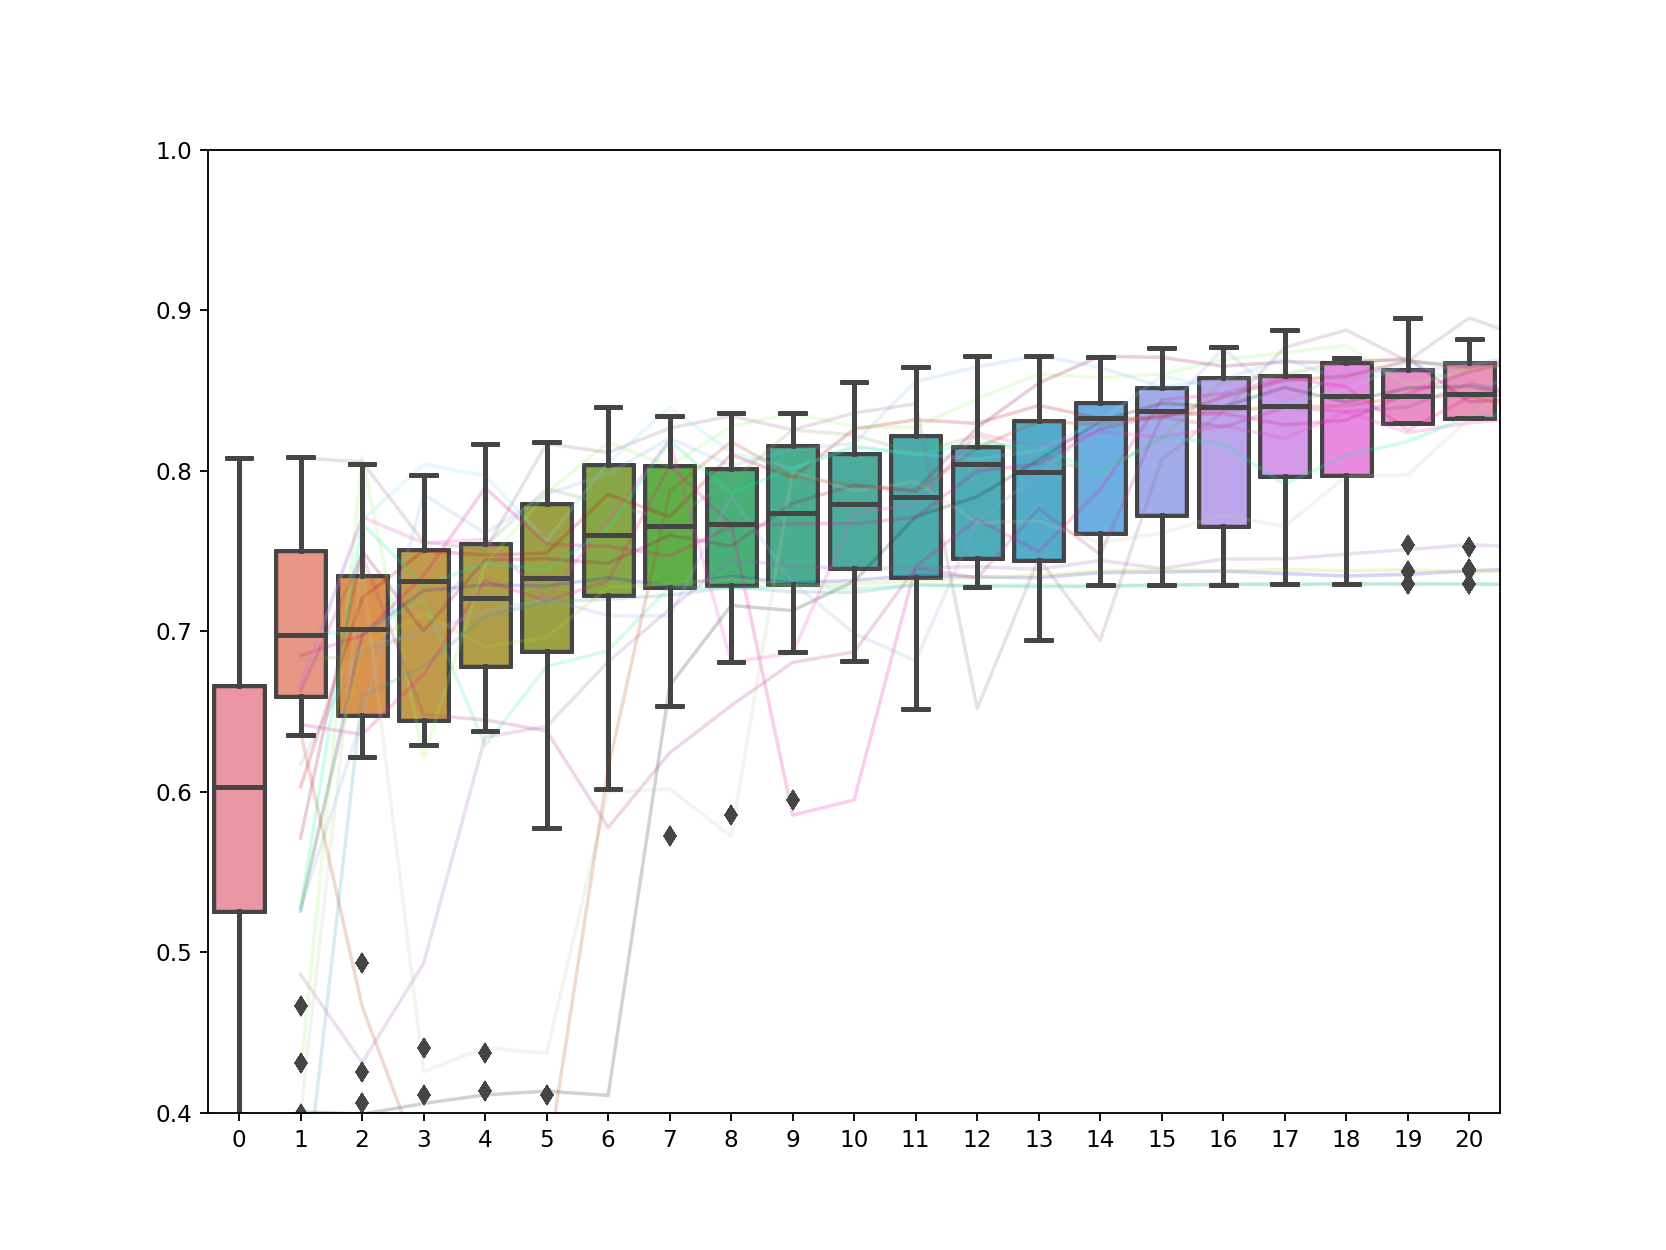

In [13]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))

for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)